In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime, timedelta, date
from statistics import mean, median, mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## Stocks Data

In [2]:
stocks = ['AAPL', 'FB', 'NFLX', 'AMZN', 'GOOG']
indices = ['^DJI', '^GSPC']
diffCols = ['Close']

# Adds a column to df for the day by day change of col
def add_day_change(df, cols):
    for col in cols:
        try:
            df[col + '_Diff'] = pd.to_numeric(df[col]).pct_change()
            df[col + "_Diff_Increase"] = df[col + '_Diff'] > 0
            df[col + '_Diff'] = df[col + '_Diff'] - df[col + '_Diff'].mean() / df[col + '_Diff'].std()
        except:
            print(f"Unable to calculate diff for {col}")
            
def add_moving_avg(df, col, n):
    try:
        df[f"Moving_Avg_{col}_{n}"] = df[col].rolling(window=n).mean().shift(1)
    except:
        print(f"Unable to calculate moving avg for {col}")

# Market dfs will store all of our dataframes for stock market data
market_dfs = {}
for symbol in stocks + indices:
    market_dfs[symbol] = pd.read_csv("../Additional Data/" + symbol + '.csv')
    add_moving_avg(market_dfs[symbol], "Close", 5)
    add_day_change(market_dfs[symbol], diffCols)
    market_dfs[symbol].dropna(inplace=True)

In [3]:
market_dfs['AAPL'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Moving_Avg_Close_5,Close_Diff,Close_Diff_Increase
5,2015-01-09,112.669998,113.250000,110.209999,112.010002,102.916725,53699500,108.296001,-0.049623,True
6,2015-01-12,112.599998,112.629997,108.800003,109.250000,100.380791,49650800,108.832001,-0.075337,False
7,2015-01-13,111.430000,112.800003,108.910004,110.220001,101.272049,67091900,109.432001,-0.041817,True
8,2015-01-14,109.040001,110.489998,108.500000,109.800003,100.886154,48956600,110.224000,-0.054506,False
9,2015-01-15,110.000000,110.059998,106.660004,106.820000,98.148056,60014000,110.634001,-0.077836,False


## Baselines - Classifiers

In [4]:
clf_baselines = {}
for key in stocks + indices:
    clf_baselines[key] = {}

In [5]:
def average(results):
    return sum(results) / len(results)

def weighted_average(results, weights):
    return results.dot(abs(weights)) / sum(abs(weights))

In [6]:
def tt_split(X, y, test_size=0.2):
    assert len(X) == len(y)
    
    n_test = int(len(X)*test_size)
    
    X_train = X.loc[:len(X)-n_test]
    y_train = y.loc[:len(X)-n_test]
    X_test = X.loc[len(X)-n_test:]
    y_test = y.loc[len(X)-n_test:]
    return X_train, X_test, y_train, y_test

### Predicting most common value

In [7]:
for symbol in stocks + indices:
    df = market_dfs[symbol]
    X_train, X_test, y_train, y_test = tt_split(df, df, test_size=0.2)
    
    pred = X_train["Close_Diff_Increase"].mode()
    X_test["Close_Diff_Increase"].apply(lambda x: x == pred)
    
    print(f'{symbol} Accuracy: {average(X_test["Close_Diff_Increase"])}')
    print(f'{symbol} Weighted Accuracy: {weighted_average(X_test["Close_Diff_Increase"], X_test["Close_Diff"])}')
    
    clf_baselines[symbol]["MostCommonVal"] = average(X_test["Close_Diff_Increase"])
    clf_baselines[symbol]["MostCommonValWeighted"] = weighted_average(X_test["Close_Diff_Increase"], X_test["Close_Diff"])


AAPL Accuracy: 0.5384615384615384
AAPL Weighted Accuracy: 0.40542682516694667
FB Accuracy: 0.5182186234817814
FB Weighted Accuracy: 0.3804825899240945
NFLX Accuracy: 0.5020242914979757
NFLX Weighted Accuracy: 0.3689496009251471
AMZN Accuracy: 0.5303643724696356
AMZN Weighted Accuracy: 0.45204100620082494
GOOG Accuracy: 0.5263157894736842
GOOG Weighted Accuracy: 0.4236848772942638
^DJI Accuracy: 0.5425101214574899
^DJI Weighted Accuracy: 0.46405613596983164
^GSPC Accuracy: 0.5546558704453441
^GSPC Weighted Accuracy: 0.4714281941511796


### Predicting the previous day's price as the current day's price (last value prediction)

In [8]:
for symbol in stocks + indices: 
    df = market_dfs[symbol]
    predictions = df["Close_Diff_Increase"][:-1]
    actual = df["Close_Diff_Increase"][1:]
    weights = df["Close_Diff"][1:]
    print(f'{symbol} Accuracy: {average(predictions.values == actual.values)}')
    print(f'{symbol} Weighted Accuracy: {weighted_average(predictions.values == actual.values, weights)}')
    
    clf_baselines[symbol]["LastVal"] = average(predictions.values == actual.values)
    clf_baselines[symbol]["LastValWeighted"] = weighted_average(predictions.values == actual.values, weights)

AAPL Accuracy: 0.4962840627580512
AAPL Weighted Accuracy: 0.4980437520019302
FB Accuracy: 0.47233691164327
FB Weighted Accuracy: 0.4666594673829773
NFLX Accuracy: 0.4731626754748142
NFLX Weighted Accuracy: 0.47770054065050305
AMZN Accuracy: 0.5177539223781998
AMZN Weighted Accuracy: 0.5166093441541652
GOOG Accuracy: 0.5127993393889347
GOOG Weighted Accuracy: 0.5144501708302146
^DJI Accuracy: 0.4929810074318745
^DJI Weighted Accuracy: 0.494742605994355
^GSPC Accuracy: 0.4764657308009909
^GSPC Weighted Accuracy: 0.48020784308493086


### Using a moving average of prices for the past n days to predict the current day's price

In [9]:
def moving_avg_pred(df, n):
    predictions = df['Close_Diff_Increase'].rolling(window=n).apply(mode, raw=False).shift(1)[n:]
    actual = df['Close_Diff_Increase'][n:]
    print('Last {} days average: {}'.format(n, average(predictions.values == actual.values)))
    print('Last {} days weighted average: {}'.format(n, weighted_average(predictions.values == actual.values, 
                                                                         df['Close_Diff'][n:])))
    
    clf_baselines[symbol]["MovingAvg"] = average(predictions.values == actual.values)
    clf_baselines[symbol]["MovingAvgWeighted"] = weighted_average(predictions.values == actual.values, df['Close_Diff'][n:])

In [10]:
for symbol in stocks + indices:
    print(symbol)
    for n in range(3, 10, 2):
        moving_avg_pred(market_dfs[symbol], n)

AAPL
Last 3 days average: 0.4946236559139785
Last 3 days weighted average: 0.4968654717641848
Last 5 days average: 0.49461474730737365
Last 5 days weighted average: 0.49625556566532014
Last 7 days average: 0.5020746887966805
Last 7 days weighted average: 0.5004246724156906
Last 9 days average: 0.4937655860349127
Last 9 days weighted average: 0.4933588675577994
FB
Last 3 days average: 0.4598842018196857
Last 3 days weighted average: 0.45104098859135555
Last 5 days average: 0.46975973487986744
Last 5 days weighted average: 0.4586339286736403
Last 7 days average: 0.47800829875518674
Last 7 days weighted average: 0.4655198866055347
Last 9 days average: 0.48212801330008315
Last 9 days weighted average: 0.47199624432779563
NFLX
Last 3 days average: 0.5028949545078577
Last 3 days weighted average: 0.5066230949442847
Last 5 days average: 0.4888152444076222
Last 5 days weighted average: 0.4895108876719637
Last 7 days average: 0.4896265560165975
Last 7 days weighted average: 0.4923743755683119
L

In [11]:
def makeDfForTimeReg(df, col, n_prev_days=5):
    new_df = pd.DataFrame(df[col])
    for i in range(n_prev_days):
        new_df[col + "_" + str(i+1)] = new_df[col].shift(i+1)
    return new_df.dropna(axis=0)

In [12]:
n_prev_days = 5
for symbol in stocks + indices:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close_Diff", n_prev_days=n_prev_days)
    df["Close_Diff_Increase"] = market_dfs[symbol]["Close_Diff_Increase"]
    
    X_cols = ["Close_Diff_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close_Diff_Increase", "Close_Diff"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = KNeighborsClassifier()
    classifier.fit(X_train, y_train["Close_Diff_Increase"])
    
    preds = classifier.predict(X_test)
    
    acc = average(preds == y_test['Close_Diff_Increase'])
    weighted_acc = weighted_average(preds == y_test['Close_Diff_Increase'], y_test['Close_Diff'])
    print(f'Last {n_prev_days} days acc: {acc}')
    print(f'Last {n_prev_days} days weighted acc: {weighted_acc}')
    
    clf_baselines[symbol]["KNeighbors"] = acc
    clf_baselines[symbol]["KNeighborsWeighted"] = weighted_acc
    

AAPL
Last 5 days acc: 0.5378486055776892
Last 5 days weighted acc: 0.5396836818735083
FB
Last 5 days acc: 0.4860557768924303
Last 5 days weighted acc: 0.45122989964050825
NFLX
Last 5 days acc: 0.4541832669322709
Last 5 days weighted acc: 0.44372693992194595
AMZN
Last 5 days acc: 0.5338645418326693
Last 5 days weighted acc: 0.5140679175438015
GOOG
Last 5 days acc: 0.4860557768924303
Last 5 days weighted acc: 0.48626437282264046
^DJI
Last 5 days acc: 0.5179282868525896
Last 5 days weighted acc: 0.512394054403039
^GSPC
Last 5 days acc: 0.4940239043824701
Last 5 days weighted acc: 0.49024901072085464


## Baselines - Regression

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
reg_baselines = {}
for key in stocks + indices:
    reg_baselines[key] = {}

In [15]:
def plot_preds_vs_actual(preds, actual, title):
    # Figsize
    plt.figure(figsize=(10,6))
    
    plt.plot(range(len(preds)), preds)
    plt.plot(range(len(preds)), actual)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Daily % Change")
    plt.gca().legend(["Predictions", "Labels"])

### Predicting the average

In [16]:
for symbol in stocks + indices: 
    df = market_dfs[symbol]
    mean_predictions = [mean(df['Close_Diff'])] * len(df['Close_Diff'])
    median_predictions = [median(df['Close_Diff'])] * len(df['Close_Diff'])
    actual = df['Close_Diff']

    print('Mean: {}'.format(mean_squared_error(actual, mean_predictions)))
    print('Median: {}'.format(mean_squared_error(actual, median_predictions)))
    
    reg_baselines[symbol]["Mean"] = mean_squared_error(actual, mean_predictions)

Mean: 0.0002485461049973261
Median: 0.00024855880180018355
Mean: 0.0003227276844210364
Median: 0.00032272797903871287
Mean: 0.0007027109992174794
Median: 0.0007052289378761726
Mean: 0.0003474481318639056
Median: 0.00034752963806127603
Mean: 0.00023404150077888913
Median: 0.00023407611261900277
Mean: 7.39338973290311e-05
Median: 7.396331711352679e-05
Mean: 7.292195168101596e-05
Median: 7.292585880449083e-05


### Predicting the previous day's price as the current day's price (last value prediction)

In [17]:
for symbol in stocks + indices: 
    print(symbol)
    preds = market_dfs[symbol]['Close_Diff'][:-1]
    actual = market_dfs[symbol]['Close_Diff'][1:]
    print(f"Last value prediction MSE: {mean_squared_error(actual.values, preds.values)}")
    
    reg_baselines[symbol]["LastVal"] = mean_squared_error(actual.values, preds.values)


AAPL
Last value prediction MSE: 0.0004958095778199441
FB
Last value prediction MSE: 0.0006462979788012922
NFLX
Last value prediction MSE: 0.0013598857408902592
AMZN
Last value prediction MSE: 0.0006853207626204931
GOOG
Last value prediction MSE: 0.0004555249281737049
^DJI
Last value prediction MSE: 0.0001519141976661679
^GSPC
Last value prediction MSE: 0.00014965979509877104


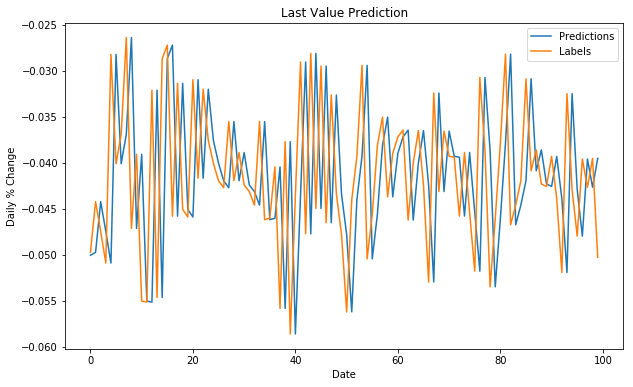

In [18]:
plot_preds_vs_actual(preds[:100], actual[:100], "Last Value Prediction")

### Using a moving average of prices for the past n days to predict the current day's price

In [19]:
n_prev_days = 4

for symbol in stocks + indices: 
    print(symbol)
    actual = market_dfs[symbol]['Close_Diff'][n_prev_days:]
    preds = market_dfs[symbol]['Close_Diff'].rolling(window=n_prev_days).apply(mean, raw=False).shift(1)[n_prev_days:]
    print(f"Last {n_prev_days} MSE: {mean_squared_error(actual.values, preds.values)}")
    
    reg_baselines[symbol]["MovingAvg"] = mean_squared_error(actual.values, preds.values)

AAPL
Last 4 MSE: 0.00031513233267016494
FB
Last 4 MSE: 0.0004151713576879585
NFLX
Last 4 MSE: 0.000863162300370415
AMZN
Last 4 MSE: 0.0004462403425329432
GOOG
Last 4 MSE: 0.0003000447514222475
^DJI
Last 4 MSE: 9.473290759734525e-05
^GSPC
Last 4 MSE: 9.389105532392272e-05


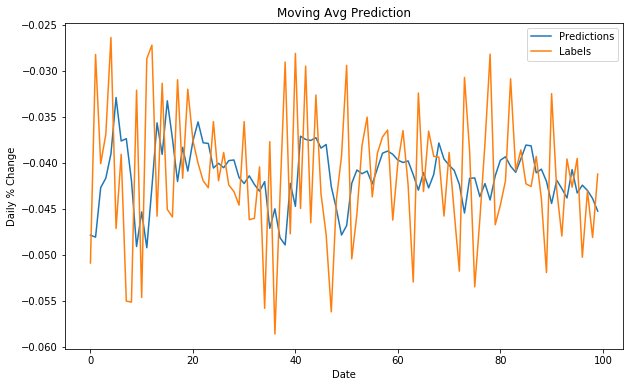

In [20]:
plot_preds_vs_actual(preds[:100], actual[:100], "Moving Avg Prediction")

### Using a time series based linear regression without news data and with the previous n days as features

In [21]:
n_prev_days = 10
for symbol in stocks + indices:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close_Diff", n_prev_days=n_prev_days)
    
    X_cols = ["Close_Diff_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close_Diff"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = LinearRegression()
    classifier.fit(X_train, y_train)
    
    preds = classifier.predict(X_test)
    
    acc = mean_squared_error(preds, y_test)
    print(f'Last {n_prev_days} days MSE: {acc}')
    
    reg_baselines[symbol]["LinReg"] = acc


AAPL
Last 10 days MSE: 0.00038164825646030384
FB
Last 10 days MSE: 0.00041551484854250256
NFLX
Last 10 days MSE: 0.0006541415228072938
AMZN
Last 10 days MSE: 0.0004300087018347806
GOOG
Last 10 days MSE: 0.000309146040804956
^DJI
Last 10 days MSE: 9.990094464266958e-05
^GSPC
Last 10 days MSE: 9.84871846633763e-05


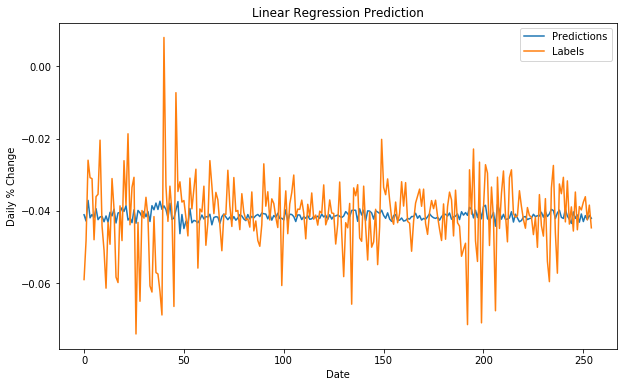

In [22]:
plot_preds_vs_actual(preds, y_test, "Linear Regression Prediction")

In [23]:
n_prev_days = 3
for symbol in stocks + indices:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close_Diff", n_prev_days=n_prev_days)
    
    X_cols = ["Close_Diff_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close_Diff"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = Lasso(alpha=0.00001)
    classifier.fit(X_train, y_train)
    
    preds = classifier.predict(X_test)
    
    acc = mean_squared_error(preds, y_test)
    print(f'Last {n_prev_days} days MSE: {acc}')
    
    reg_baselines[symbol]["LassoReg"] = acc

AAPL
Last 3 days MSE: 0.00037224999247653385
FB
Last 3 days MSE: 0.00041026578826348914
NFLX
Last 3 days MSE: 0.000619752002531244
AMZN
Last 3 days MSE: 0.00037845476327699946
GOOG
Last 3 days MSE: 0.00029558380702768104
^DJI
Last 3 days MSE: 9.91808121705312e-05
^GSPC
Last 3 days MSE: 9.791536658391446e-05


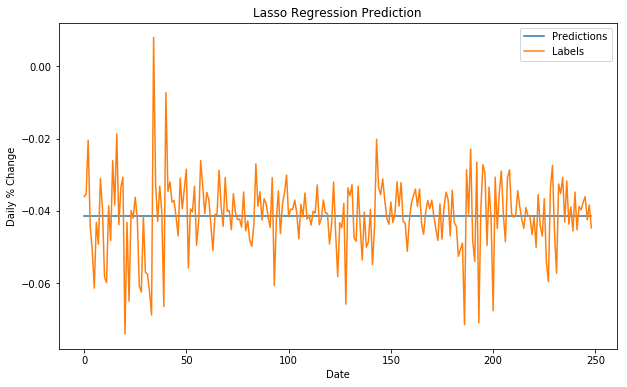

In [24]:
plot_preds_vs_actual(preds, y_test, "Lasso Regression Prediction")

In [25]:
n_prev_days = 8
for symbol in stocks + indices:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close", n_prev_days=n_prev_days)
    
    X_cols = ["Close_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = Lasso(alpha=1)
    classifier.fit(X_train, y_train)
    
    preds = classifier.predict(X_test)
    
    acc = mean_squared_error(preds, y_test)
    print(f'Last {n_prev_days} days MSE: {acc}')

AAPL
Last 8 days MSE: 13.616612357875354
FB
Last 8 days MSE: 10.911601034526134
NFLX
Last 8 days MSE: 61.041854478943634
AMZN
Last 8 days MSE: 1093.5291351540468
GOOG
Last 8 days MSE: 388.15628794944274
^DJI
Last 8 days MSE: 62035.042513242835
^GSPC
Last 8 days MSE: 731.6860845986175


/Users/adamskrocki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


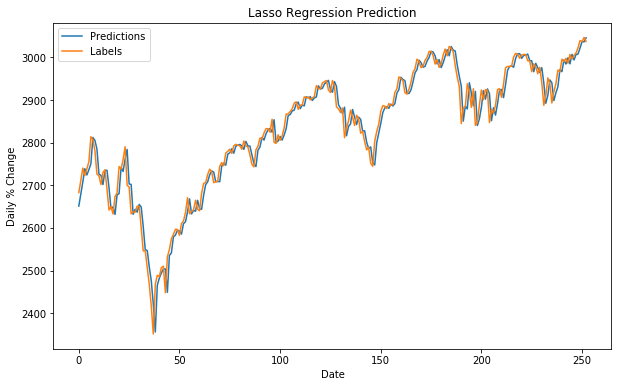

In [26]:
plot_preds_vs_actual(preds, y_test, "Lasso Regression Prediction")

In [27]:
n_prev_days = 8
for symbol in stocks + indices:
    print(symbol)
    
    df = makeDfForTimeReg(market_dfs[symbol], "Close_Diff", n_prev_days=n_prev_days)
    
    X_cols = ["Close_Diff_" + str(i+1) for i in range(n_prev_days)]
    y_cols = ["Close_Diff"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = Ridge(alpha=5)
    classifier.fit(X_train, y_train)
    
    preds = classifier.predict(X_test)
    
    acc = mean_squared_error(preds, y_test)
    print(f'Last {n_prev_days} days MSE: {acc}')
    
    reg_baselines[symbol]["RidgeReg"] = acc

AAPL
Last 8 days MSE: 0.00038732494466115765
FB
Last 8 days MSE: 0.00041342070192508957
NFLX
Last 8 days MSE: 0.00063280371376022
AMZN
Last 8 days MSE: 0.0003859308083706901
GOOG
Last 8 days MSE: 0.0002980164541513341
^DJI
Last 8 days MSE: 9.960895643808292e-05
^GSPC
Last 8 days MSE: 9.830420632122305e-05


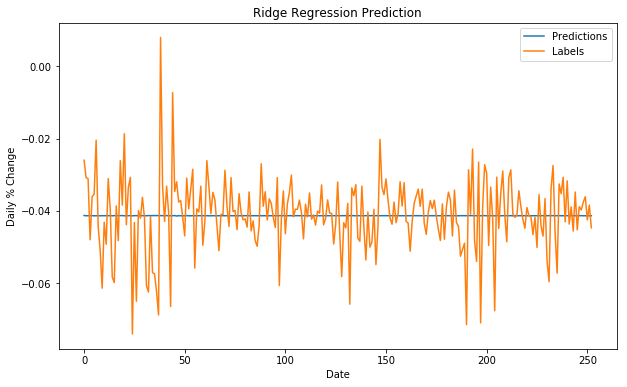

In [28]:
plot_preds_vs_actual(preds, y_test, "Ridge Regression Prediction")

Looks like it learns to basically just predict the previous day (i.e. weight for the previous day is high and rest are low)

In [29]:
pd.DataFrame(reg_baselines)

,AAPL,FB,NFLX,AMZN,GOOG,^DJI,^GSPC
LassoReg,0.000372,0.000410,0.000620,0.000378,0.000296,0.000099,0.000098
LastVal,0.000496,0.000646,0.001360,0.000685,0.000456,0.000152,0.000150
LinReg,0.000382,0.000416,0.000654,0.000430,0.000309,0.000100,0.000098
Mean,0.000249,0.000323,0.000703,0.000347,0.000234,0.000074,0.000073
MovingAvg,0.000315,0.000415,0.000863,0.000446,0.000300,0.000095,0.000094
RidgeReg,0.000387,0.000413,0.000633,0.000386,0.000298,0.000100,0.000098


In [30]:
pd.DataFrame(clf_baselines)

,AAPL,FB,NFLX,AMZN,GOOG,^DJI,^GSPC
KNeighbors,0.537849,0.486056,0.454183,0.533865,0.486056,0.517928,0.494024
KNeighborsWeighted,0.539684,0.451230,0.443727,0.514068,0.486264,0.512394,0.490249
LastVal,0.496284,0.472337,0.473163,0.517754,0.512799,0.492981,0.476466
LastValWeighted,0.498044,0.466659,0.477701,0.516609,0.514450,0.494743,0.480208
MostCommonVal,0.538462,0.518219,0.502024,0.530364,0.526316,0.542510,0.554656
MostCommonValWeighted,0.405427,0.380483,0.368950,0.452041,0.423685,0.464056,0.471428
MovingAvg,0.493766,0.482128,0.472984,0.511222,0.484622,0.505403,0.497922
MovingAvgWeighted,0.493359,0.471996,0.480478,0.503381,0.476151,0.507964,0.501394


# Using News to Predict Stock Movement

## Introduction 
Predicting the stock market has always been a very difficult task, despite the volumes of data available for analysis. Many different factors that influence the stock market are at play - not only related to the company associated with a stock, but also related to the public's perception of a stock, recent economic events, political developments, and more. Investment and asset management firms have spent billions on building models that are able to accurately assess the future direction of stocks, and even they are not always successful; it's nearly impossible to include everything that might have an effect on a stock into a predictive model. One big step towards doing this in recent years has been incorporating news data in models. The news contains huge amounts of information about what's going on in the world - some of it undoubtedly relevant to the stock market. Our goal is to determine what the predictive power of